In [2]:
import json
from PIL import Image
import matplotlib
import matplotlib.patches as patches
import os
import matplotlib.pyplot as plt
import sys
from ultralytics import YOLO
import numpy as np
import torch
import onnx
import onnxruntime as ort
import torchvision.transforms as transforms
import torch
from torchvision import transforms
sys.path.append(r'C:\Users\itay\Desktop\IDF')

from utils.bboxes_conversions import *
from utils.metrics import *
from utils.postprocesses import *
from utils.preprocesses import *


In [3]:
# Replace 'your_annotations.json' with the actual path to your JSON file.
file_path = fr'C:\Users\itay\Desktop\IDF\datasets\COCO\annotations_trainval2017\annotations\instances_val2017.json'

# Load the JSON file
with open(file_path, 'r') as json_file:
    annotations = json.load(json_file)

In [4]:
classes = {val['id']:val['name'] for val in annotations['categories']}

In [5]:
image_dict = {image['id']:{**image, **{'annotations':[]}} for image in annotations['images']}
for ann in annotations['annotations']:
    if classes[ann['category_id']]=='person':
        image_dict[ann['image_id']]['annotations'] += [(ann['bbox'], ann['category_id'], classes[ann['category_id']])]
    
image_dict = {image_data['file_name']:image_data for image_id, image_data in image_dict.items()} # only images with person instances

In [6]:
person_images = {image_name:image_metadata for image_name, image_metadata in image_dict.items() if len(image_metadata['annotations'])>0}

In [83]:
# Load an image from a file
IMAGES_PATH = fr'C:\Users\itay\Desktop\IDF\datasets\COCO\val2017'
IMAGE_NAME = fr'000000397279.jpg'
image = Image.open(os.path.join(IMAGES_PATH, IMAGE_NAME))
image_ann = image_dict[IMAGE_NAME]    

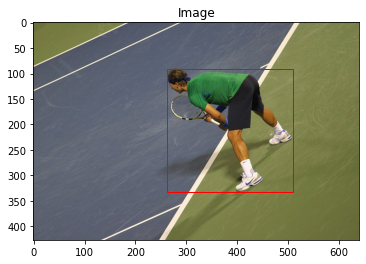

In [84]:
IMAGE_NAME = fr'000000397279.jpg'
image = Image.open(os.path.join(IMAGES_PATH, IMAGE_NAME))
image_ann = image_dict[IMAGE_NAME]    

# Create a figure and an Axes object
fig, ax = plt.subplots()

plt.imshow(image)
plt.title('Image');

for detection, category_id, category  in image_ann['annotations']:
    # Assume each detection is a dictionary with 'bbox' key
    x, y, width, height = detection
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# YOLO V8

In [85]:
# Load a model
yolov8 = YOLO("yolov8n.pt") 

In [94]:
IMAGES_PATH = fr'C:\Users\itay\Desktop\IDF\datasets\COCO\val2017'
IMAGE_NAME = fr'000000397279.jpg'
image_path = os.path.join(IMAGES_PATH, IMAGE_NAME)

In [95]:
predictions = yolov8(image_path)


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000397279.jpg: 448x640 1 person, 1 tennis racket, 116.8ms
Speed: 1.0ms preprocess, 116.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


In [96]:
predictions[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 0., 38.])
conf: tensor([0.9481, 0.6773])
data: tensor([[262.1058,  89.6564, 510.0139, 331.9223,   0.9481,   0.0000],
        [269.5547, 139.4523, 374.3339, 206.3186,   0.6773,  38.0000]])
id: None
is_track: False
orig_shape: (427, 640)
shape: torch.Size([2, 6])
xywh: tensor([[386.0599, 210.7894, 247.9081, 242.2660],
        [321.9443, 172.8855, 104.7792,  66.8663]])
xywhn: tensor([[0.6032, 0.4937, 0.3874, 0.5674],
        [0.5030, 0.4049, 0.1637, 0.1566]])
xyxy: tensor([[262.1058,  89.6564, 510.0139, 331.9223],
        [269.5547, 139.4523, 374.3339, 206.3186]])
xyxyn: tensor([[0.4095, 0.2100, 0.7969, 0.7773],
        [0.4212, 0.3266, 0.5849, 0.4832]])

In [97]:
# predictions[0].boxes.xywh

In [98]:
# Image.open(image_path)
image = Image.open(os.path.join(IMAGES_PATH, IMAGE_NAME))
img_array = np.array(image)
img_tensor = torch.from_numpy(img_array)

### Draw YOLO V8 Predictions on image

In [99]:
# predictions[0].boxes[0].cls
# predictions[0].boxes.cls

In [100]:
# predictions[0].boxes.cls

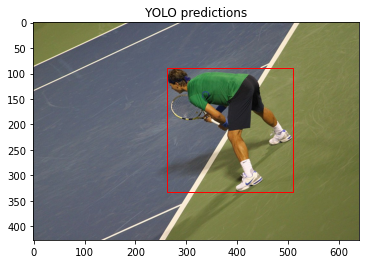

In [101]:
fig, axs = plt.subplots()
plt.imshow(image)
plt.title('YOLO predictions');

for bbox, cls in zip(predictions[0].boxes.xywh, predictions[0].boxes.cls):
    if cls!=0:
        continue
    # Assume each detection is a dictionary with 'bbox' key
    x_center, y_center, width, height = bbox
    x = x_center-width/2
    y = y_center-height/2
#     print(bbox)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axs.add_patch(rect)

plt.show()



# Convert YOLO to onnx

In [102]:
yolov8.export(format='onnx')

Ultralytics YOLOv8.0.202  Python-3.8.3 torch-2.1.0 CPU (Intel Core(TM) i7-8750H 2.20GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success  1.2s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (3.0s)
Results saved to C:\Users\itay\Desktop\IDF\NBs
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8n.onnx'

In [117]:
onnx_model = onnx.load(fr'C:\Users\itay\Desktop\IDF\models\yolov8n.onnx')
ort_session = ort.InferenceSession(fr'C:\Users\itay\Desktop\IDF\models\yolov8n.onnx')


In [118]:
transform = create_onnx_preprocess_transform()

In [119]:
# Apply YOLO onnx on input image

input_onnx_img = np.array(transform(image))
print(f'Input shape: {input_onnx_img.shape}')
ort_inputs = {ort_session.get_inputs()[0].name: input_onnx_img}
ort_outs = ort_session.run(None, ort_inputs)
print(f'output shape: {ort_outs[0].shape}')

Input shape: (1, 3, 640, 640)
output shape: (1, 84, 8400)


In [106]:
padded_image = PadToSize((640, 660))(image)

In [107]:
min_conf = 0.1
nms_iou_threshold = 0.5

# postprocess onnx preds
preds = ort_outs[0][0]
preds_bboxes, preds_classes, preds_objectness = filter_onnx_preds(preds, min_conf)
# print(f'bboxes: {preds_bboxes.shape},  classes:{preds_classes.shape}, scores:{preds_objectness.shape}')

# NMS
keep_indices = non_max_suppression(preds_bboxes, preds_objectness, iou_threshold=nms_iou_threshold)
preds_bboxes, preds_objectness, preds_classes = preds_bboxes[keep_indices], preds_objectness[keep_indices], preds_classes[keep_indices]

In [110]:
preds_bboxes

array([[     386.04,      316.69,         248,       242.2]], dtype=float32)

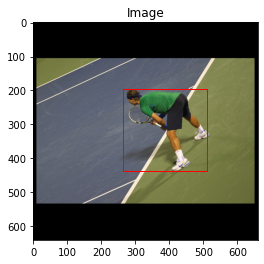

In [109]:

padded_image = PadToSize((640, 660))(image)

fig, axs = plt.subplots()
plt.imshow(padded_image)
plt.title('Image');

for bbox, cls in zip(preds_bboxes, preds_classes):
#     if cls!=0:
#         continue
    # Assume each detection is a dictionary with 'bbox' key
    x_center, y_center, width, height = bbox
    x = x_center-width/2
    y = y_center-height/2
#     print(bbox);
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axs.add_patch(rect)

plt.show()

##### Convert annotation bboxes (due to the padding), we just need to conduct: y += (640-480)/2

In [126]:
yolo_input_size = 640
image_width = image.width
image_height = image.height

In [127]:
labels_xywh = np.array([ann[0] for ann in image_ann['annotations']])
labels_xywh[:, 0] += (yolo_input_size-image_width)/2
labels_xywh[:, 1] += (yolo_input_size-image_height)/2

##### Convert Onnx yolo preds to xywh

In [128]:
# preds_bboxes # (n_preds, 4): x_center, y_center, width, height
preds_xywh = xycwh_to_xywh(preds_bboxes)

##### Convert YOLO (original) preds to padded image xywh

In [129]:
yolo_org_xywh_padded = predictions[0].boxes.xywh[predictions[0].boxes.cls==0]
yolo_org_xywh_padded[:, 0] += (yolo_input_size-image_width)/2
yolo_org_xywh_padded[:, 1] += (yolo_input_size-image_height)/2
yolo_org_xywh_padded = xycwh_to_xywh(yolo_org_xywh_padded)

Now they are all comparible (padded image xywh):

labels_xywh           # Annotaions

preds_xywh            # onnx preds

yolo_org_xywh_padded  # yolo preds

# Compare predictions to labels

In [130]:
print(f'Num of objects: {labels_xywh.shape[0]}')
print(f'Num of detections: {preds_xywh.shape[0]}')

Num of objects: 11
Num of detections: 6


#### Labels vs onnx preds

In [131]:
# labels_xywh # (n_preds, 4): x_top_left, y_top_left, width, height
# preds_xywh # (n_preds, 4): x_top_left, y_top_left, width, height


precision, recall = calculate_precision_recall(preds_xywh, labels_xywh, iou_threshold=0.2)
f_score = calc_f1(precision, recall)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'f_score: {f_score:.2f}')


Precision: 1.00
Recall: 0.50
f_score: 0.67


##### Yolo preds (as labels) vs onnx preds

In [132]:
yolo_org_xywh_padded = predictions[0].boxes.xywh[predictions[0].boxes.cls==0]
yolo_org_xywh_padded[:, 0] += (yolo_input_size-image_width)/2
yolo_org_xywh_padded[:, 1] += (yolo_input_size-image_height)/2
yolo_org_xywh_padded = xycwh_to_xywh(yolo_org_xywh_padded)

precision, recall = calculate_precision_recall(preds_xywh, yolo_org_xywh_padded, iou_threshold=0.2)
f_score = calc_f1(precision, recall)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'f_score: {f_score:.2f}')


Precision: 0.83
Recall: 1.00
f_score: 0.91


#### Sanity check to see the yolo_org_xywh_padded fits to the padded image:

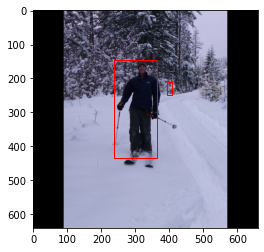

In [933]:
# Create a figure and an Axes object
fig, ax = plt.subplots()

plt.imshow(padded_image)

for detection in yolo_org_xywh_padded:
# for detection in predictions[0].boxes.xywh:
    # Assume each detection is a dictionary with 'bbox' key
    x, y, width, height = detection
#     x_center, y_center, width, height = detection
#     x = x_center-width/2
#     y = y_center-height/2
    
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Go over all person images in validation set and calc metrics

In [17]:
# person_images
IMAGES_PATH = fr'C:\Users\itay\Desktop\IDF\datasets\COCO\val2017'


In [21]:
# Load a model
yolov8 = YOLO("yolov8n.pt") 

onnx_model = onnx.load(fr'C:\Users\itay\Desktop\IDF\models\yolov8n.onnx')
ort_session = ort.InferenceSession(fr'C:\Users\itay\Desktop\IDF\models\yolov8n.onnx')
transform = create_onnx_preprocess_transform()

In [51]:
min_conf = 0.1
nms_iou_threshold = 0.5
metric_iou_threshold = 0.2

In [55]:
label_precision_list, label_recall_list, label_f_score_list, org_precision_list, org_recall_list, org_f_score_list = [], [], [], [], [], []
ult_precision_list,ult_recall_list,ult_f_score_list = [], [], []
image_name_list, converted_labels_list, converted_yolo_preds, converted_onnx_preds = [], [], [], []

for image_file_name, image_meta_data in list(person_images.items()):
#     continue
    image_labels = [ann[0] for ann in image_meta_data['annotations']]
    image = Image.open(os.path.join(IMAGES_PATH, image_file_name))
    image_path = os.path.join(IMAGES_PATH, image_file_name)
    if len(np.array(image).shape)!=3:
        continue
    
    
    yolo_predictions = yolov8(image_path)
    
    # Apply YOLO onnx on input image
    # padded_image = PadToSize((640, 660))(image)
    input_onnx_img = np.array(transform(image))
    ort_inputs = {ort_session.get_inputs()[0].name: input_onnx_img}
    ort_outs = ort_session.run(None, ort_inputs)
    
    # postprocess onnx preds
    preds = ort_outs[0][0]
    preds_bboxes, preds_classes, preds_objectness = filter_onnx_preds(preds, min_conf)
    # print(f'bboxes: {preds_bboxes.shape},  classes:{preds_classes.shape}, scores:{preds_objectness.shape}')

    # NMS
    keep_indices = non_max_suppression(preds_bboxes, preds_objectness, iou_threshold=nms_iou_threshold)
    preds_bboxes, preds_objectness, preds_classes = preds_bboxes[keep_indices], preds_objectness[keep_indices], preds_classes[keep_indices]
    # print(f'Num of preds after NMS: {len(keep_indices)}')
    
    # Convert labels to padded image xywh
    yolo_input_size = 640
    image_width = image.width
    image_height = image.height

    labels_xywh = np.array(image_labels)
    labels_xywh[:, 0] += (yolo_input_size-image_width)/2
    labels_xywh[:, 1] += (yolo_input_size-image_height)/2

    # Convert Onnx yolo preds to xywh
    onnx_preds_xywh = xycwh_to_xywh(preds_bboxes)

    # Convert YOLO (original) preds to padded image xywh
    yolo_org_xywh_padded = predictions[0].boxes.xywh[predictions[0].boxes.cls==0]
    yolo_org_xywh_padded[:, 0] += (yolo_input_size-image_width)/2
    yolo_org_xywh_padded[:, 1] += (yolo_input_size-image_height)/2
    yolo_org_xywh_padded = xycwh_to_xywh(yolo_org_xywh_padded)



    # Calc scores  
    label_precision, label_recall = calculate_precision_recall(onnx_preds_xywh, labels_xywh, iou_threshold=metric_iou_threshold)
    label_f_score = calc_f1(label_precision, label_recall)
    org_precision, org_recall = calculate_precision_recall(onnx_preds_xywh, yolo_org_xywh_padded, iou_threshold=metric_iou_threshold)
    org_f_score = calc_f1(org_precision, org_recall)
    
    ult_precision, ult_recall = calculate_precision_recall(yolo_org_xywh_padded, labels_xywh, iou_threshold=metric_iou_threshold)
    ult_f_score = calc_f1(ult_precision, ult_recall)
    
#     print(f'Precision: {label_precision:.2f}')
#     print(f'Recall: {label_recall:.2f}')
#     print(f'f_score: {label_f_score:.2f}')
#     print(f'Precision: {org_precision:.2f}')
#     print(f'Recall: {org_recall:.2f}')
#     print(f'f_score: {org_f_score:.2f}')

    label_precision_list.append(label_precision)
    label_recall_list.append(label_recall)
    label_f_score_list.append(label_f_score)
    
    org_precision_list.append(org_precision)
    org_recall_list.append(org_recall)
    org_f_score_list.append(org_f_score)
    
    ult_precision_list.append(ult_precision)
    ult_recall_list.append(ult_recall)
    ult_f_score_list.append(ult_f_score)
    
    image_name_list.append(image_file_name)
    
    converted_labels_list.append(labels_xywh)
    converted_yolo_preds.append(yolo_org_xywh_padded)
    converted_onnx_preds.append(onnx_preds_xywh)


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000397133.jpg: 448x640 2 persons, 1 cup, 4 bowls, 1 potted plant, 1 oven, 93.7ms
Speed: 1.0ms preprocess, 93.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000252219.jpg: 448x640 3 persons, 1 traffic light, 1 umbrella, 1 chair, 77.8ms
Speed: 1.0ms preprocess, 77.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000087038.jpg: 480x640 11 persons, 2 bicycles, 1 skateboard, 81.8ms
Speed: 1.0ms preprocess, 81.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000480985.jpg: 640x480 3 persons, 2 motorcycles, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000296649.jpg: 448

Speed: 3.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000486438.jpg: 448x640 2 persons, 7 donuts, 72.8ms
Speed: 1.0ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000400573.jpg: 640x480 1 person, 1 pizza, 1 donut, 83.8ms
Speed: 1.0ms preprocess, 83.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000370677.jpg: 448x640 3 persons, 16 donuts, 81.8ms
Speed: 2.0ms preprocess, 81.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000502737.jpg: 640x480 3 persons, 1 cup, 2 donuts, 2 cakes, 91.8ms
Speed: 1.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\da

Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000494869.jpg: 640x448 2 persons, 1 cat, 1 dog, 1 bottle, 1 cup, 5 bowls, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000033638.jpg: 640x448 1 person, 2 bottles, 1 cup, 1 bowl, 1 chair, 1 potted plant, 1 oven, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000329219.jpg: 448x640 1 person, 1 dog, 2 cups, 2 spoons, 1 chair, 1 clock, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000356387.jpg: 448x640 10 persons, 1 bicycle, 2 motorcycles, 94.7ms
Speed: 3.0ms preprocess, 94.7ms i


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000261982.jpg: 640x480 1 person, 2 cars, 1 skateboard, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000099242.jpg: 448x640 1 person, 1 skis, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000314709.jpg: 448x640 1 person, 1 skis, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000541055.jpg: 384x640 6 persons, 1 skis, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000409475.jpg: 480x640 2 persons, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.0ms p

Speed: 2.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000130599.jpg: 480x640 1 person, 2 giraffes, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000456559.jpg: 480x640 1 person, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000101068.jpg: 448x640 1 person, 1 sports ball, 2 baseball bats, 91.8ms
Speed: 1.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000140640.jpg: 448x640 3 persons, 2 cakes, 1 potted plant, 87.8ms
Speed: 1.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\

Speed: 2.0ms preprocess, 95.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000520264.jpg: 480x640 2 persons, 5 bottles, 1 wine glass, 2 bowls, 1 pizza, 1 microwave, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000151000.jpg: 448x640 4 persons, 1 bicycle, 1 tie, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000100624.jpg: 448x640 4 persons, 1 car, 1 cell phone, 80.8ms
Speed: 2.0ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000332570.jpg: 640x512 2 persons, 1 cell phone, 104.7ms
Speed: 3.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64

Speed: 2.0ms preprocess, 104.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000036936.jpg: 416x640 2 persons, 4 cups, 3 bowls, 2 couchs, 1 dining table, 1 tv, 1 vase, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000059044.jpg: 448x640 12 persons, 2 handbags, 1 remote, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000172946.jpg: 640x448 11 persons, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000234607.jpg: 640x480 3 persons, 3 remotes, 85.8ms
Speed: 3.0ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000236166.jpg: 640x448 1 person, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000153529.jpg: 640x480 4 persons, 2 backpacks, 1 handbag, 3 suitcases, 119.7ms
Speed: 2.0ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000253835.jpg: 480x640 2 persons, 1 train, 1 traffic light, 3 backpacks, 119.7ms
Speed: 1.0ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000219271.jpg: 640x448 8 persons, 2 buss, 92.7ms
Speed: 3.0ms preprocess, 92.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000460841.jpg: 480x640 1 person, 1 cat, 1 bottle,

Speed: 2.0ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000411817.jpg: 480x640 8 persons, 5 tvs, 107.7ms
Speed: 1.0ms preprocess, 107.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000546964.jpg: 480x640 8 persons, 1 bowl, 7 chairs, 2 couchs, 1 potted plant, 1 vase, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000215259.jpg: 640x448 2 persons, 6 remotes, 97.8ms
Speed: 2.0ms preprocess, 97.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000147729.jpg: 480x640 5 persons, 1 cell phone, 95.7ms
Speed: 3.0ms preprocess, 95.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Us


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000047828.jpg: 320x640 8 persons, 1 car, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000183716.jpg: 640x480 3 persons, 2 ties, 109.7ms
Speed: 3.0ms preprocess, 109.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000271997.jpg: 640x512 1 person, 1 tie, 113.7ms
Speed: 2.0ms preprocess, 113.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000008532.jpg: 448x640 1 person, 1 tie, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000390555.jpg: 448x640 25 persons, 3 ties, 1 sports ball, 104.7ms
Speed: 2.0ms preprocess, 104.7ms infere

Speed: 2.0ms preprocess, 107.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000143572.jpg: 448x640 17 persons, 1 tennis racket, 3 chairs, 111.7ms
Speed: 2.0ms preprocess, 111.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000229849.jpg: 640x448 11 persons, 7 chairs, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000039551.jpg: 448x640 1 person, 1 sports ball, 1 tennis racket, 103.7ms
Speed: 1.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000193348.jpg: 640x448 1 person, 1 toothbrush, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\U

Speed: 3.0ms preprocess, 128.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000420916.jpg: 416x640 4 persons, 1 boat, 1 bench, 1 backpack, 105.7ms
Speed: 2.0ms preprocess, 105.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000296224.jpg: 480x640 1 car, 1 bus, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000122606.jpg: 480x640 1 person, 1 car, 1 bus, 1 train, 102.7ms
Speed: 1.0ms preprocess, 102.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000439715.jpg: 480x640 9 persons, 2 horses, 2 umbrellas, 98.7ms
Speed: 2.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000003934.jpg: 640x480 8 persons, 1 wine glass, 1 couch, 134.6ms
Speed: 3.0ms preprocess, 134.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000047740.jpg: 384x640 2 persons, 1 surfboard, 103.7ms
Speed: 1.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000077460.jpg: 640x448 6 persons, 5 kites, 107.7ms
Speed: 1.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000014439.jpg: 416x640 15 persons, 1 car, 2 backpacks, 1 kite, 1 chair, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000447314.jpg: 480x640 6 persons, 97.7ms
Speed: 2

Speed: 2.0ms preprocess, 149.6ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000290248.jpg: 480x640 18 persons, 1 car, 1 suitcase, 128.6ms
Speed: 4.0ms preprocess, 128.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000532058.jpg: 480x640 3 persons, 2 bottles, 1 bed, 1 remote, 129.7ms
Speed: 3.0ms preprocess, 129.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000578093.jpg: 480x640 1 train, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000301061.jpg: 640x480 2 persons, 2 elephants, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\

Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000410510.jpg: 448x640 1 person, 1 sports ball, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000039951.jpg: 448x640 1 person, 1 sports ball, 1 tennis racket, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000306700.jpg: 640x480 1 person, 1 pizza, 1 dining table, 97.7ms
Speed: 1.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000146457.jpg: 480x640 2 persons, 2 bottles, 1 bowl, 2 pizzas, 1 chair, 93.7ms
Speed: 1.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 6


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000084270.jpg: 480x640 14 persons, 1 backpack, 2 handbags, 3 suitcases, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000267191.jpg: 480x640 3 persons, 2 elephants, 98.7ms
Speed: 2.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000422836.jpg: 480x640 3 persons, 1 suitcase, 122.7ms
Speed: 2.0ms preprocess, 122.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000463522.jpg: 480x640 3 persons, 2 bicycles, 1 horse, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000213547.jpg: 640x480 3 persons, 1 bottle, 1 sand

Speed: 6.0ms preprocess, 161.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000474078.jpg: 480x640 4 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 129.7ms
Speed: 3.0ms preprocess, 129.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000000872.jpg: 640x640 2 persons, 149.6ms
Speed: 4.0ms preprocess, 149.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000032038.jpg: 640x448 1 person, 1 pizza, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000261732.jpg: 448x640 1 person, 1 tennis racket, 133.6ms
Speed: 2.0ms preprocess, 133.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\i

Speed: 3.0ms preprocess, 167.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000407083.jpg: 640x480 2 persons, 1 dog, 126.7ms
Speed: 3.0ms preprocess, 126.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000212226.jpg: 448x640 1 person, 1 car, 1 truck, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000394206.jpg: 480x640 9 persons, 1 car, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000220858.jpg: 480x640 2 persons, 1 boat, 1 bird, 98.7ms
Speed: 4.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\

Speed: 2.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000342128.jpg: 640x512 8 persons, 1 tennis racket, 4 chairs, 106.7ms
Speed: 3.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000035279.jpg: 480x640 1 person, 1 backpack, 1 laptop, 1 remote, 1 cell phone, 2 books, 105.7ms
Speed: 1.0ms preprocess, 105.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000503755.jpg: 640x480 1 person, 1 tennis racket, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000320642.jpg: 416x640 4 persons, 1 remote, 89.8ms
Speed: 3.0ms preprocess, 89.8ms inference, 2.0ms postprocess per image at shape (1, 3, 41


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000488251.jpg: 384x640 2 persons, 2 horses, 85.8ms
Speed: 1.0ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000229601.jpg: 448x640 7 persons, 1 baseball glove, 92.8ms
Speed: 1.0ms preprocess, 92.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000427160.jpg: 512x640 4 persons, 1 baseball glove, 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000437205.jpg: 640x384 1 person, 1 banana, 93.7ms
Speed: 1.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000434204.jpg: 448x640 4 persons, 1 bench, 1 skateboard, 1 chair, 92.8ms
Speed: 2

Speed: 2.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000154644.jpg: 640x640 1 person, 1 cell phone, 126.7ms
Speed: 7.0ms preprocess, 126.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000474039.jpg: 416x640 1 person, 1 couch, 2 beds, 1 teddy bear, 84.8ms
Speed: 1.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000381587.jpg: 640x448 4 persons, 1 bottle, 6 cups, 22 bowls, 1 broccoli, 3 dining tables, 81.8ms
Speed: 2.0ms preprocess, 81.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000461751.jpg: 576x640 3 persons, 2 cars, 1 motorcycle, 133.6ms
Speed: 4.0ms preprocess, 133.6ms inference, 2.0ms postprocess per image at

Speed: 2.0ms preprocess, 100.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000090956.jpg: 448x640 1 person, 1 skis, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000313562.jpg: 480x640 2 persons, 98.7ms
Speed: 2.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000258388.jpg: 448x640 3 persons, 1 frisbee, 2 skateboards, 97.7ms
Speed: 1.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000273711.jpg: 480x640 3 persons, 11 bowls, 5 chairs, 1 dining table, 109.7ms
Speed: 2.0ms preprocess, 109.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Deskto


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000422706.jpg: 448x640 3 persons, 5 boats, 116.7ms
Speed: 3.0ms preprocess, 116.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000178982.jpg: 448x640 3 persons, 1 motorcycle, 1 traffic light, 246.3ms
Speed: 4.0ms preprocess, 246.3ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000408696.jpg: 480x640 2 persons, 2 toilets, 170.5ms
Speed: 3.0ms preprocess, 170.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000144300.jpg: 448x640 3 persons, 1 car, 1 motorcycle, 1 bus, 138.6ms
Speed: 3.0ms preprocess, 138.6ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000007816.jpg: 448x640 9 persons, 1 motorcycle, 133


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000568981.jpg: 448x640 3 persons, 1 skateboard, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000461009.jpg: 640x640 8 persons, 1 apple, 1 orange, 1 chair, 130.6ms
Speed: 5.0ms preprocess, 130.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000563648.jpg: 640x480 12 persons, 1 skateboard, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000532855.jpg: 480x640 1 person, 94.7ms
Speed: 1.0ms preprocess, 94.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000038210.jpg: 640x448 2 persons, 1 skis, 103.7ms
Speed: 2.0ms preprocess, 103.7


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000319607.jpg: 640x640 2 persons, 1 bicycle, 1 traffic light, 138.6ms
Speed: 4.0ms preprocess, 138.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000302452.jpg: 640x640 1 person, 1 giraffe, 1 frisbee, 124.7ms
Speed: 6.0ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000058393.jpg: 512x640 3 persons, 1 bench, 105.7ms
Speed: 1.0ms preprocess, 105.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000441468.jpg: 640x448 2 persons, 3 cars, 1 fire hydrant, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000277005.jpg: 448x640 10 persons, 1 bicycle, 3 ca

Speed: 1.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000087476.jpg: 640x448 9 persons, 1 skateboard, 81.8ms
Speed: 2.0ms preprocess, 81.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000490515.jpg: 448x640 1 person, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000445602.jpg: 480x640 3 persons, 99.7ms
Speed: 1.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000037689.jpg: 448x640 9 persons, 1 snowboard, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000400044.jpg: 

Speed: 7.0ms preprocess, 130.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000520009.jpg: 544x640 4 persons, 1 car, 1 bus, 1 traffic light, 1 clock, 138.6ms
Speed: 5.0ms preprocess, 138.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000362682.jpg: 448x640 1 person, 1 bus, 2 trucks, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000396518.jpg: 480x640 1 person, 1 skateboard, 119.7ms
Speed: 3.0ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000065288.jpg: 448x640 13 persons, 1 bird, 2 potted plants, 107.7ms
Speed: 2.0ms preprocess, 107.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000492968.jpg: 448x640 1 person, 1 snowboard, 127.7ms
Speed: 3.0ms preprocess, 127.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000023359.jpg: 448x640 1 person, 1 snowboard, 123.7ms
Speed: 2.0ms preprocess, 123.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000063047.jpg: 576x640 4 persons, 121.7ms
Speed: 5.0ms preprocess, 121.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000426376.jpg: 640x480 1 person, 1 snowboard, 106.7ms
Speed: 3.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000364884.jpg: 480x640 7 persons, 1 kite, 102.7ms
Speed: 4.0ms preprocess, 102.7ms inference, 

Speed: 2.0ms preprocess, 121.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000098392.jpg: 640x480 3 persons, 5 cars, 1 bus, 1 clock, 111.7ms
Speed: 2.0ms preprocess, 111.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000142472.jpg: 480x640 2 persons, 5 cars, 1 bus, 113.7ms
Speed: 2.0ms preprocess, 113.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000516143.jpg: 480x640 1 person, 1 bus, 132.6ms
Speed: 2.0ms preprocess, 132.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000042628.jpg: 448x640 5 persons, 1 fire hydrant, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\ID


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000528399.jpg: 448x640 1 person, 6 cups, 1 knife, 1 spoon, 1 sandwich, 1 orange, 1 dining table, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000054605.jpg: 640x640 2 persons, 1 wine glass, 2 cups, 3 forks, 2 knifes, 1 cake, 2 chairs, 1 dining table, 132.6ms
Speed: 7.0ms preprocess, 132.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000248400.jpg: 448x640 1 person, 2 bowls, 1 pizza, 104.7ms
Speed: 1.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000063965.jpg: 448x640 2 persons, 1 cake, 110.7ms
Speed: 2.0ms preprocess, 110.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desk


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000181816.jpg: 480x640 1 person, 1 car, 1 bench, 3 potted plants, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000052007.jpg: 640x480 4 persons, 1 bus, 85.8ms
Speed: 1.0ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000283318.jpg: 448x640 3 cars, 1 fire hydrant, 104.7ms
Speed: 1.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000049259.jpg: 640x448 1 person, 1 bench, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000278749.jpg: 448x640 9 persons, 2 cars, 89.8ms
Speed: 2.0ms preprocess, 89

Speed: 1.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000327701.jpg: 448x640 4 persons, 1 sports ball, 1 baseball bat, 93.7ms
Speed: 1.0ms preprocess, 93.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000575081.jpg: 448x640 1 person, 1 potted plant, 1 tv, 1 remote, 1 keyboard, 1 book, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000144984.jpg: 640x448 1 person, 1 couch, 1 remote, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000074646.jpg: 640x480 5 persons, 1 fire hydrant, 1 kite, 1 cup, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postprocess per im

Speed: 1.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000275392.jpg: 640x480 1 person, 1 horse, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000205333.jpg: 192x640 2 persons, 1 skis, 74.8ms
Speed: 1.0ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000005529.jpg: 640x448 1 person, 1 skis, 83.8ms
Speed: 2.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000197658.jpg: 640x608 1 person, 1 baseball glove, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\0

Speed: 2.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000528578.jpg: 448x640 2 clocks, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000216296.jpg: 448x640 3 persons, 1 tennis racket, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000248616.jpg: 448x640 3 persons, 1 sports ball, 1 tennis racket, 92.8ms
Speed: 1.0ms preprocess, 92.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000484978.jpg: 512x640 1 person, 1 wine glass, 7 cups, 2 dining tables, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\

Speed: 3.0ms preprocess, 95.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000580197.jpg: 480x640 3 persons, 2 ties, 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000114049.jpg: 640x448 1 person, 1 traffic light, 5 suitcases, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000320743.jpg: 384x640 10 persons, 12 elephants, 80.8ms
Speed: 2.0ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000453001.jpg: 480x640 2 persons, 2 benchs, 1 potted plant, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\i

Speed: 1.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000398377.jpg: 480x640 4 persons, 103.7ms
Speed: 3.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000048564.jpg: 640x448 1 person, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000336628.jpg: 640x448 7 persons, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000553731.jpg: 448x640 4 persons, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000073533.jpg: 480x640 3 persons, 1 co

Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000109992.jpg: 448x640 2 persons, 1 skis, 97.7ms
Speed: 1.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000395903.jpg: 384x640 1 person, 3 surfboards, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000204329.jpg: 640x448 5 persons, 1 surfboard, 83.8ms
Speed: 2.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000331604.jpg: 448x640 2 persons, 1 kite, 1 surfboard, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\CO


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000373705.jpg: 448x640 5 persons, 1 fire hydrant, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000548780.jpg: 448x640 6 persons, 1 handbag, 86.8ms
Speed: 1.0ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000270297.jpg: 448x640 1 train, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000192716.jpg: 640x544 2 cars, 1 truck, 1 stop sign, 119.7ms
Speed: 4.0ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000137727.jpg: 384x640 1 person, 2 cars, 1 train, 1 truck, 7 suitcases, 78.8ms
Speed: 2.0ms 


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000562581.jpg: 448x640 1 person, 1 sports ball, 1 tennis racket, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000451435.jpg: 416x640 1 person, 1 sports ball, 1 tennis racket, 81.8ms
Speed: 2.0ms preprocess, 81.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000345397.jpg: 480x640 4 persons, 1 tie, 1 cell phone, 106.7ms
Speed: 3.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000094157.jpg: 640x384 8 persons, 1 clock, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000173008.jpg: 480x640 1 person, 1 spoon, 1 

Speed: 2.0ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000038118.jpg: 448x640 1 person, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000019221.jpg: 480x640 1 person, 1 broccoli, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000473406.jpg: 640x480 1 person, 2 bottles, 1 cup, 1 sink, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000161879.jpg: 576x640 1 person, 1 bench, 1 skateboard, 115.7ms
Speed: 3.0ms preprocess, 115.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\itay\Desktop\IDF\dat


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000506707.jpg: 448x640 7 persons, 1 car, 1 baseball glove, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000051610.jpg: 448x640 1 person, 1 dining table, 1 laptop, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000546475.jpg: 640x384 2 persons, 1 dining table, 2 cell phones, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000302882.jpg: 512x640 1 person, 108.7ms
Speed: 3.0ms preprocess, 108.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000363188.jpg: 448x640 11 persons, 92.7ms
Speed: 2.0ms p

Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000018770.jpg: 448x640 1 person, 1 tie, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000397303.jpg: 480x640 8 persons, 1 backpack, 9 chairs, 1 laptop, 1 cell phone, 1 book, 96.7ms
Speed: 1.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000144932.jpg: 448x640 2 boats, 91.7ms
Speed: 2.0ms preprocess, 91.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000368961.jpg: 480x640 2 persons, 2 elephants, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000383339.jpg: 448x640 1 person, 102.7ms
Speed: 2.0ms preprocess, 102.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000288430.jpg: 480x640 4 persons, 2 kites, 101.7ms
Speed: 3.0ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000012639.jpg: 640x480 17 persons, 1 baseball bat, 1 baseball glove, 97.7ms
Speed: 1.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000510095.jpg: 448x640 1 person, 1 baseball bat, 98.7ms
Speed: 2.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000128748.jpg: 640x512 3 persons, 1 baseball bat, 113.7ms
Speed: 2.0ms prepr


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000186624.jpg: 576x640 1 person, 1 train, 121.7ms
Speed: 3.0ms preprocess, 121.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000568147.jpg: 640x480 3 persons, 2 cars, 2 parking meters, 97.7ms
Speed: 1.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000246454.jpg: 640x640 2 persons, 2 dogs, 1 sheep, 107.7ms
Speed: 4.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000401446.jpg: 480x640 1 person, 1 umbrella, 2 handbags, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000161609.jpg: 480x640 4 persons, 1 dog, 2 handbags, 90.8ms



image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000166478.jpg: 448x640 2 persons, 5 bowls, 2 couchs, 1 laptop, 2 books, 89.8ms
Speed: 1.0ms preprocess, 89.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000280918.jpg: 480x640 1 person, 1 oven, 91.8ms
Speed: 3.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000581317.jpg: 384x640 1 person, 1 cell phone, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000284764.jpg: 448x640 1 person, 84.8ms
Speed: 1.0ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000157767.jpg: 448x640 10 persons, 2 backpacks, 4 handbags, 1 cup, 1 bowl, 1 dini

Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000074860.jpg: 448x640 1 person, 1 snowboard, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000361506.jpg: 480x640 1 person, 1 car, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000365521.jpg: 640x448 7 persons, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000288862.jpg: 640x448 2 persons, 1 clock, 86.8ms
Speed: 2.0ms preprocess, 86.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000018519.jpg


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000302107.jpg: 640x448 3 persons, 1 baseball bat, 1 baseball glove, 93.7ms
Speed: 1.0ms preprocess, 93.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000133969.jpg: 448x640 13 persons, 3 baseball gloves, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000207306.jpg: 640x480 2 persons, 1 teddy bear, 90.7ms
Speed: 3.0ms preprocess, 90.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000565877.jpg: 640x448 1 person, 1 couch, 1 laptop, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000117197.jpg: 480x640 1 person, 1 cell phone, 93.7m


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000007088.jpg: 640x480 1 person, 1 truck, 1 umbrella, 92.8ms
Speed: 2.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000468632.jpg: 480x640 3 persons, 1 frisbee, 101.7ms
Speed: 1.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000013774.jpg: 480x640 1 person, 1 kite, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000499031.jpg: 640x448 3 persons, 1 banana, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000574823.jpg: 640x480 5 persons, 1 sports ball, 98.7ms
Speed: 2.0ms preprocess, 98.7m


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000002532.jpg: 640x480 1 person, 1 skis, 102.7ms
Speed: 2.0ms preprocess, 102.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000338304.jpg: 640x448 9 persons, 5 sheeps, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000182611.jpg: 640x480 3 persons, 1 cup, 1 spoon, 4 bowls, 1 sandwich, 1 dining table, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000395180.jpg: 512x640 6 persons, 2 bicycles, 1 boat, 98.7ms
Speed: 1.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000472623.jpg: 640x448 3 persons, 1 bicycle, 1


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000192964.jpg: 640x448 1 person, 1 skateboard, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000450559.jpg: 640x448 1 person, 2 skateboards, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000422886.jpg: 640x640 1 person, 1 hot dog, 108.7ms
Speed: 4.0ms preprocess, 108.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000407650.jpg: 448x640 1 person, 1 snowboard, 95.7ms
Speed: 1.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000167572.jpg: 448x640 1 person, 1 orange, 1 teddy bear, 86.8ms
Speed: 2.0ms preprocess


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000441247.jpg: 448x640 5 persons, 1 backpack, 5 chairs, 2 couchs, 1 clock, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000025096.jpg: 640x480 2 persons, 2 knifes, 1 cake, 1 dining table, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000527750.jpg: 640x448 1 person, 1 refrigerator, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000491213.jpg: 480x640 4 cars, 1 motorcycle, 1 truck, 94.7ms
Speed: 2.0ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000200839.jpg: 480x640 1 per


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000243989.jpg: 576x640 5 persons, 114.7ms
Speed: 6.0ms preprocess, 114.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000581357.jpg: 640x640 5 persons, 1 skateboard, 118.7ms
Speed: 6.0ms preprocess, 118.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000476119.jpg: 448x640 1 person, 4 cars, 1 skateboard, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000179898.jpg: 480x640 8 persons, 2 hot dogs, 4 chairs, 2 dining tables, 109.7ms
Speed: 2.0ms preprocess, 109.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000187055.jpg: 640x448 3 persons, 2 sports balls, 1 bottle


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000507037.jpg: 480x640 14 persons, 4 bicycles, 2 backpacks, 89.8ms
Speed: 1.0ms preprocess, 89.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000260925.jpg: 480x640 1 cat, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000574702.jpg: 640x448 6 persons, 7 motorcycles, 1 umbrella, 96.7ms
Speed: 3.0ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000246963.jpg: 448x640 7 persons, 5 motorcycles, 1 stop sign, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000272136.jpg: 448x640 1 train, 96.7ms
Speed: 1.0ms preproces

Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000390246.jpg: 448x640 1 person, 1 surfboard, 89.8ms
Speed: 1.0ms preprocess, 89.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000548524.jpg: 448x640 1 person, 2 boats, 93.7ms
Speed: 2.0ms preprocess, 93.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000039480.jpg: 448x640 1 person, 1 tennis racket, 96.7ms
Speed: 1.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000493905.jpg: 640x576 13 persons, 10 chairs, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\v

Speed: 1.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000353518.jpg: 416x640 2 boats, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000463618.jpg: 480x640 2 persons, 1 couch, 1 tv, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000148999.jpg: 448x640 2 persons, 90.8ms
Speed: 1.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000475484.jpg: 640x448 2 persons, 5 cars, 2 traffic lights, 83.8ms
Speed: 1.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000331317.jpg: 512x640 1 clock, 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000145020.jpg: 384x640 7 persons, 1 stop sign, 5 teddy bears, 84.8ms
Speed: 1.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000073153.jpg: 640x448 1 person, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000560911.jpg: 640x512 1 person, 1 couch, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000263425.jpg: 448x640 2 persons, 1 boat, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postp

Speed: 1.0ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000081738.jpg: 480x640 1 person, 1 cake, 1 bed, 1 vase, 96.7ms
Speed: 1.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000442463.jpg: 640x480 1 person, 1 skateboard, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000450399.jpg: 480x640 12 persons, 1 bowl, 2 donuts, 2 chairs, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000516173.jpg: 640x416 2 persons, 2 surfboards, 104.7ms
Speed: 2.0ms preprocess, 104.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 C:\Users\i

Speed: 2.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000133000.jpg: 448x640 1 person, 1 train, 91.7ms
Speed: 2.0ms preprocess, 91.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000365208.jpg: 640x608 1 person, 3 umbrellas, 1 chair, 130.6ms
Speed: 4.0ms preprocess, 130.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000450075.jpg: 480x640 2 persons, 116.7ms
Speed: 1.0ms preprocess, 116.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000060932.jpg: 448x640 6 persons, 1 handbag, 2 ties, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COC


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000015660.jpg: 352x640 1 person, 4 kites, 2 surfboards, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000039914.jpg: 640x512 7 persons, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000304404.jpg: 448x640 18 persons, 2 baseball bats, 1 baseball glove, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000570688.jpg: 480x640 11 persons, 21 kites, 107.7ms
Speed: 1.0ms preprocess, 107.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000236599.jpg: 448x640 4 persons, 2 birds, 1 umbrella, 4 kites, 8

Speed: 2.0ms preprocess, 95.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000341094.jpg: 480x640 1 elephant, 103.7ms
Speed: 4.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000161978.jpg: 448x640 16 persons, 13 skateboards, 102.7ms
Speed: 18.0ms preprocess, 102.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000521819.jpg: 480x640 10 persons, 4 cars, 1 frisbee, 114.7ms
Speed: 2.0ms preprocess, 114.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000303499.jpg: 640x448 1 person, 4 horses, 2 cows, 104.7ms
Speed: 3.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\da

Speed: 2.0ms preprocess, 100.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000089296.jpg: 448x640 2 persons, 2 sports balls, 2 baseball bats, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000320490.jpg: 448x640 3 persons, 1 sports ball, 2 baseball bats, 1 bottle, 134.6ms
Speed: 17.0ms preprocess, 134.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000160012.jpg: 480x640 1 person, 2 cars, 1 bottle, 2 pizzas, 1 dining table, 110.7ms
Speed: 1.0ms preprocess, 110.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000365886.jpg: 480x640 1 person, 1 cell phone, 92.8ms
Speed: 3.0ms preprocess, 92.8ms inference, 1.0ms postprocess pe


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000231580.jpg: 480x640 8 persons, 101.7ms
Speed: 1.0ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000350003.jpg: 480x640 2 persons, 1 car, 1 bus, 1 truck, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000295420.jpg: 480x640 2 persons, 2 cars, 2 trucks, 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000050006.jpg: 480x640 2 boats, 1 bench, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000443426.jpg: 640x480 1 person, 112.7ms
Speed: 2.0ms preprocess, 112.7ms inference,


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000384808.jpg: 640x480 1 person, 1 bottle, 2 sinks, 109.7ms
Speed: 3.0ms preprocess, 109.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000291634.jpg: 640x448 8 persons, 1 bicycle, 4 motorcycles, 1 umbrella, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000329614.jpg: 288x640 1 person, 9 cars, 1 bus, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000131138.jpg: 480x640 1 person, 3 cups, 1 chair, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 1 book, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\00000

Speed: 2.0ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000468332.jpg: 448x640 15 persons, 1 car, 1 knife, 1 cake, 1 dining table, 98.7ms
Speed: 1.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000016451.jpg: 640x640 1 person, 2 umbrellas, 1 handbag, 2 suitcases, 2 surfboards, 2 chairs, 125.7ms
Speed: 7.0ms preprocess, 125.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000031620.jpg: 640x480 3 persons, 1 chair, 1 couch, 121.7ms
Speed: 1.0ms preprocess, 121.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000420840.jpg: 448x640 1 person, 1 dining table, 114.7ms
Speed: 2.0ms preprocess, 114.7ms inference, 2.0ms postprocess


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000082812.jpg: 384x640 14 persons, 1 train, 2 backpacks, 1 handbag, 3 suitcases, 92.8ms
Speed: 1.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000076547.jpg: 480x640 1 person, 2 bicycles, 1 train, 1 bench, 1 backpack, 1 laptop, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000018837.jpg: 480x640 4 persons, 1 car, 1 bus, 1 truck, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000153011.jpg: 480x640 8 persons, 3 cars, 1 bus, 2 trucks, 2 chairs, 89.8ms
Speed: 2.0ms preprocess, 89.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\dataset


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000377393.jpg: 480x640 3 boats, 1 umbrella, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000060507.jpg: 448x640 10 persons, 1 sports ball, 101.7ms
Speed: 1.0ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000548339.jpg: 576x640 3 persons, 1 baseball bat, 1 bottle, 108.7ms
Speed: 3.0ms preprocess, 108.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000473869.jpg: 448x640 1 person, 1 wine glass, 1 bowl, 2 chairs, 1 potted plant, 1 vase, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000074092.jpg: 640x448 7 pe


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000342397.jpg: 448x640 4 persons, 1 skis, 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000164885.jpg: 448x640 3 persons, 1 skis, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000431545.jpg: 448x640 2 persons, 1 baseball glove, 88.8ms
Speed: 3.0ms preprocess, 88.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000516677.jpg: 480x640 7 persons, 2 backpacks, 2 skiss, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000387916.jpg: 448x640 10 persons, 1 skis, 1 snowboard, 94.7ms
Speed: 2.0ms prep

Speed: 2.0ms preprocess, 110.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000266400.jpg: 416x640 3 persons, 1 bicycle, 5 motorcycles, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000427338.jpg: 416x640 2 motorcycles, 91.8ms
Speed: 1.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000102411.jpg: 448x640 10 persons, 1 car, 1 motorcycle, 1 traffic light, 96.7ms
Speed: 1.0ms preprocess, 96.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000499622.jpg: 640x608 1 person, 1 motorcycle, 137.6ms
Speed: 5.0ms preprocess, 137.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 C:\User

Speed: 1.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000561223.jpg: 448x640 1 person, 1 surfboard, 84.8ms
Speed: 2.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000206579.jpg: 480x640 2 persons, 2 cakes, 1 dining table, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000451155.jpg: 480x640 1 person, 1 bed, 1 tv, 1 laptop, 91.8ms
Speed: 1.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000150417.jpg: 480x640 2 persons, 1 bottle, 2 cups, 1 cake, 2 dining tables, 1 refrigerator, 107.7ms
Speed: 2.0ms preprocess, 107.7ms inference, 2.0ms postprocess per image at shape 

Speed: 2.0ms preprocess, 86.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000471567.jpg: 480x640 1 giraffe, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000334371.jpg: 448x640 1 person, 2 cars, 2 buss, 3 traffic lights, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000285894.jpg: 448x640 3 persons, 2 giraffes, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000054967.jpg: 640x448 1 person, 11 cars, 1 truck, 2 traffic lights, 85.8ms
Speed: 1.0ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 C:\Users\i

Speed: 2.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000554266.jpg: 256x640 1 bed, 1 clock, 78.8ms
Speed: 1.0ms preprocess, 78.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000161925.jpg: 640x480 2 persons, 1 pizza, 98.7ms
Speed: 1.0ms preprocess, 98.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000064898.jpg: 448x640 2 persons, 1 surfboard, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000547854.jpg: 640x640 1 person, 1 pizza, 1 dining table, 112.7ms
Speed: 4.0ms preprocess, 112.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO


image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000181421.jpg: 448x640 4 persons, 1 boat, 2 umbrellas, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000477227.jpg: 448x640 2 trains, 92.7ms
Speed: 2.0ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000119641.jpg: 480x640 15 persons, 8 elephants, 87.8ms
Speed: 2.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000040083.jpg: 448x640 3 persons, 1 bicycle, 2 cars, 2 chairs, 100.7ms
Speed: 2.0ms preprocess, 100.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 C:\Users\itay\Desktop\IDF\datasets\COCO\val2017\000000244496.jpg: 640x384 1 person, 1 tie, 91.8ms
Speed: 2.0ms preprocess, 9

In [49]:
# input_onnx_img.shape


2

In [177]:
padded_image = PadToSize((640, 660))(image)

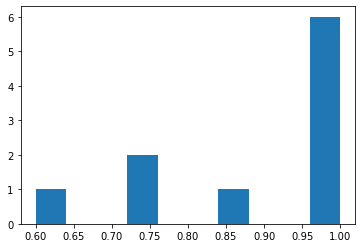

In [27]:
plt.hist(label_precision_list);

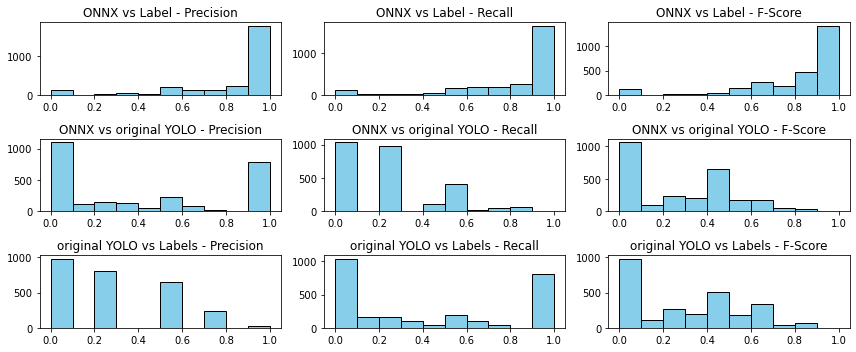

In [58]:
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 5))

# List of data and corresponding titles
data_lists = [
    (label_precision_list, 'ONNX vs Label - Precision'),
    (label_recall_list, 'ONNX vs Label - Recall'),
    (label_f_score_list, 'ONNX vs Label - F-Score'),
    
    (org_precision_list, 'ONNX vs original YOLO - Precision'),
    (org_recall_list, 'ONNX vs original YOLO - Recall'),
    (org_f_score_list, 'ONNX vs original YOLO - F-Score'),
    
    (ult_precision_list, 'original YOLO vs Labels - Precision'),
    (ult_recall_list, 'original YOLO vs Labels - Recall'),
    (ult_f_score_list, 'original YOLO vs Labels - F-Score')
]

# Create histograms for each data list
for i, (data, title) in enumerate(data_lists):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.hist(data, bins=10, range=(0, 1), color='skyblue', edgecolor='black')
    ax.set_title(title)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

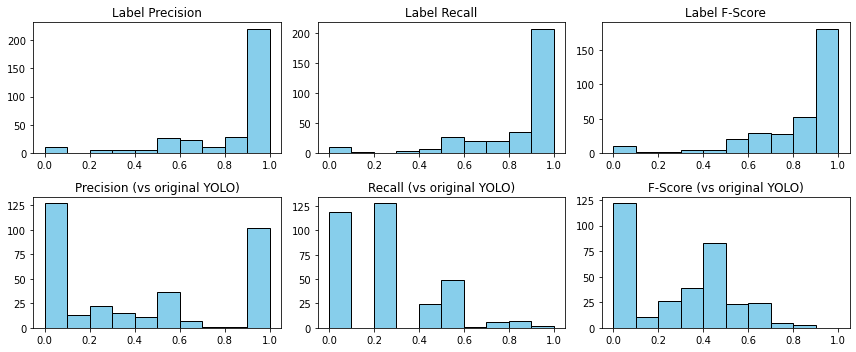

In [40]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

# List of data and corresponding titles
data_lists = [
    (label_precision_list, 'Label Precision'),
    (label_recall_list, 'Label Recall'),
    (label_f_score_list, 'Label F-Score'),
    (org_precision_list, 'Precision (vs original YOLO)'),
    (org_recall_list, 'Recall (vs original YOLO)'),
    (org_f_score_list, 'F-Score (vs original YOLO)')
]

# Create histograms for each data list
for i, (data, title) in enumerate(data_lists):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.hist(data, bins=10, range=(0, 1), color='skyblue', edgecolor='black')
    ax.set_title(title)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [179]:
# image_labels
# image_meta_data['annotations']
# predictions[0].boxes.cls

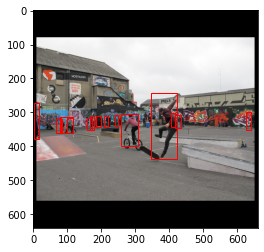

In [178]:
draw_ann_on_image(padded_image, onnx_preds_xywh)

In [884]:
# fig, axs = plt.subplots()
# plt.imshow(image)
# plt.title('YOLO predictions');

# for bbox, cls in zip(predictions[0].boxes.xywh, predictions[0].boxes.cls):
#     if cls!=0:
#         continue
#     # Assume each detection is a dictionary with 'bbox' key
#     x_center, y_center, width, height = bbox
#     x = x_center-width/2
#     y = y_center-height/2
# #     print(bbox)
#     rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
#     axs.add_patch(rect)

# plt.show()

#### Test whether we can use class confidence as objectness:

In [ ]:
import pandas as pd
df = pd.DataFrame(ort_outs[0][0])
df[df.columns[::-1]]

In [265]:
ort_outs[0][0].shape

(84, 8400)

In [290]:

dd = [k for k in ort_outs[0][0][:4,:][0] if k>(10**-1)]
len(dd)
    

8400

(array([       3993,        2829,        1169,         113,          79,          52,          33,          32,          27,          73]),
 array([       6.25,      69.578,      132.91,      196.24,      259.56,      322.89,      386.22,      449.55,      512.88,      576.21,      639.53]),
 <BarContainer object of 10 artists>)

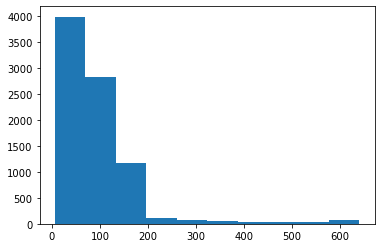

In [293]:
# plt.hist(ort_outs[0][0][:4,:]);
plt.hist(ort_outs[0][0][:4,:][3])

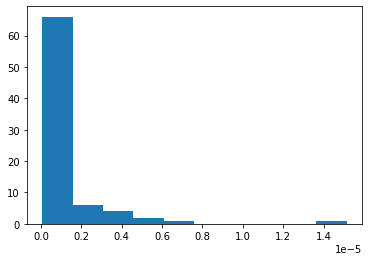

In [269]:
plt.hist(ort_outs[0][0][4:,50]);

In [294]:
ort_outs[0][0][4:].shape

(80, 8400)

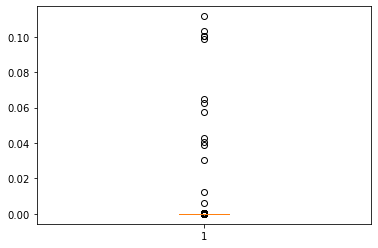

In [303]:
data = ort_outs[0][0][4:]
max_vals = np.max(data, axis=0)  # Find the maximum values along the first axis
sorted_data = np.sort(data, axis=0)  # Sort the data along the first axis
second_max_vals = sorted_data[-2, :]  # Take the second-highest values

# Calculate the differences between max and second max
diffs = max_vals - second_max_vals
plt.boxplot(diffs);

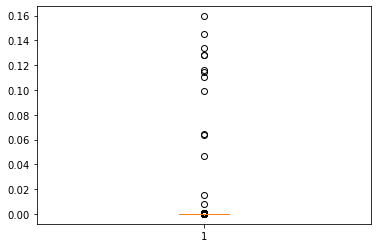

In [304]:
plt.boxplot(np.max(ort_outs[0][0][4:], axis=0));

Reshape the output tensor:
The output tensor might need to be reshaped or split into components representing bounding box coordinates, object confidence, and class probabilities.

Filter out low-confidence predictions:
Apply a threshold to the object confidence scores to retain only high-confidence predictions.

Non-Maximum Suppression (NMS):
Apply NMS to remove duplicate and overlapping bounding boxes.

Translate predictions into the desired format:
Translate the remaining predictions into the desired format (x_center, y_center, width, height, class).

Here's a rough outline of how the code might look, assuming the output tensor can be split into its components easily:

In [225]:
(50 * 56)*3

8400

# DEBUG

In [739]:
[key for key,val in image_dict.items() if len(val['annotations'])>9]

['000000087038.jpg',
 '000000296649.jpg',
 '000000303818.jpg',
 '000000463730.jpg',
 '000000329323.jpg',
 '000000239274.jpg',
 '000000233771.jpg',
 '000000016228.jpg',
 '000000474028.jpg',
 '000000078915.jpg',
 '000000057597.jpg',
 '000000559842.jpg',
 '000000217285.jpg',
 '000000171190.jpg',
 '000000301135.jpg',
 '000000356387.jpg',
 '000000107226.jpg',
 '000000231508.jpg',
 '000000412894.jpg',
 '000000361103.jpg',
 '000000464089.jpg',
 '000000406611.jpg',
 '000000162092.jpg',
 '000000386352.jpg',
 '000000312237.jpg',
 '000000410650.jpg',
 '000000089648.jpg',
 '000000158548.jpg',
 '000000253742.jpg',
 '000000059044.jpg',
 '000000172946.jpg',
 '000000120420.jpg',
 '000000036494.jpg',
 '000000190923.jpg',
 '000000163314.jpg',
 '000000259571.jpg',
 '000000219271.jpg',
 '000000511599.jpg',
 '000000558114.jpg',
 '000000361919.jpg',
 '000000123213.jpg',
 '000000439854.jpg',
 '000000481390.jpg',
 '000000326248.jpg',
 '000000546964.jpg',
 '000000432898.jpg',
 '000000163057.jpg',
 '00000000751

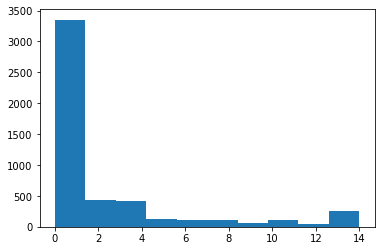

In [701]:
plt.hist([len(val['annotations']) for key,val in image_dict.items()]);

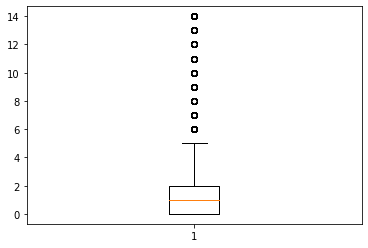

In [702]:
plt.boxplot([len(val['annotations']) for key,val in image_dict.items()]);

In [640]:
import numpy as np

def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas of the two bounding boxes
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]

    # Calculate IoU
    iou = intersection_area / (area1 + area2 - intersection_area)

    return iou

def calculate_precision_recall(pred_boxes, true_boxes, iou_threshold):
    """
    x: The x-coordinate of the top-left corner of the bounding box.
    y: The y-coordinate of the top-left corner of the bounding box.
    width: The width of the bounding box.
    height: The height of the bounding box.
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pred_box in pred_boxes:
        matched = False
        for true_box in true_boxes:
            iou = calculate_iou(pred_box, true_box)
            if iou >= iou_threshold:
                true_positives += 1
                matched = True
                break
        if not matched:
            false_positives += 1

    false_negatives = len(true_boxes) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

# Example usage
pred_boxes = np.array([[50, 50, 39, 30], [60, 60, 40, 40], [80, 80, 20, 20]])
true_boxes = np.array([[50, 50, 30, 30], [70, 70, 30, 30]])

precision, recall = calculate_precision_recall(pred_boxes, true_boxes, iou_threshold=0.5)
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.6666666666666666
Recall: 1.0


In [24]:
image_ids = [image['id'] for image in annotations['images']]
ann_ids = [ann['image_id'] for ann in annotations['annotations']]

# ids

In [19]:
# [ann_id for ann_id in ann_ids if ann_id in image_ids]

In [20]:
# annotations['annotations'][1]

In [246]:
(50*56)*3

8400

In [250]:
640/50

12.8

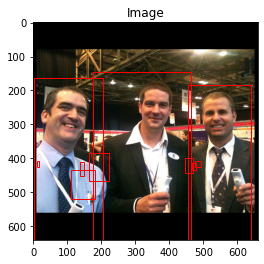

In [592]:
[ann[0] for ann in image_ann['annotations']]

# Create a figure and an Axes object
fig, ax = plt.subplots()

plt.imshow(padded_image)
plt.title('Image');

for detection, category_id, category  in image_ann['annotations']:
    # Assume each detection is a dictionary with 'bbox' key
    x, y, width, height = detection
    y *= 640/420
    height *= 640/420
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
# PadToSize((640, 600))(np.ones((639,639)))

# PadToSize((640, 660))(image)

input_onnx_img[0][::-1].shape

# plt.imshow(input_onnx_img[0].T);

input_onnx_img = img_array.astype(np.float32)

input_onnx_img = np.expand_dims(input_onnx_img.T, axis=0)
input_onnx_img.shape
# input_onnx_img = torch.tensor(input_onnx_img)
# Assume img_tensor is your image in torch.tensor format


# transform = transforms.Compose([
#     transforms.Resize((640, 640)),  # Resize image to 640x640
#     transforms.ToTensor(),  # This will also normalize pixel values to [0, 1]
# ])

# # Apply the transformations
# input_onnx_img = transform(image)
# input_onnx_img.shape


# resize
# normalize = -mean/std
# tensor = 0-1

In [ ]:
# yolov8
input_image = arr[0]
model = yolov8
# Pass the input image through the model
with torch.no_grad():
    x = input_image
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.modules.linear.Linear):
            x = torch.flatten(x, 1)
            print(f"Layer: Flatten, Feature Map Size: {x.size()}")
        x = layer(x)
        print(f"Layer: {name}, Feature Map Size: {x.size()}")

In [ ]:
arr = np.random.randn(1, 3, 640, 640).astype(np.float32)
arr = np.transpose(arr, (0, 2, 3, 1))  # Convert to HWC format
arr = (arr * 255).astype(np.uint8)  # Convert to uint8 and scale values to 0-255
# yolov8(arr[0])

In [ ]:
all_layer_names = [node.name for node in onnx_model.graph.node]

# Assume img is your input image array preprocessed as per YOLOv8 requirements
img = np.random.randn(1, 3, 640, 640).astype(np.float32)  # Replace with actual image preprocessing

# Perform inference
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)

# Print the shape of the feature space after each layer
for i, out in enumerate(ort_outs):
    print(f'Shape after layer {all_layer_names[i]}: {out.shape}')

[     445.13      341.53      44.861      49.295]
[     445.22      341.57      44.346      49.817]
[     445.55      341.47      45.232      49.534]
[     445.44      341.26       44.56      48.495]
[     316.96      365.14       288.2      383.19]
[     315.64      365.65      289.21      383.19]
[     545.74      383.33      188.91      357.51]
[     545.42      383.49       188.7      358.32]
[     103.78      372.04      207.07      372.61]
[     102.89      371.91       205.2      372.48]
[      323.8      365.14      290.56      382.32]
[     317.87      365.35      285.05      381.95]
[     318.55       365.4      291.43      382.74]
[      545.3      382.32      189.21      355.14]
[     545.04      382.25      189.46      354.64]
[     103.59       371.4      206.93      372.49]
[     103.97      371.06      207.39      373.25]
[     103.42      371.24      206.55      371.93]
[     322.22      365.74      286.04      379.34]
[     318.85      365.76      282.71      380.17]


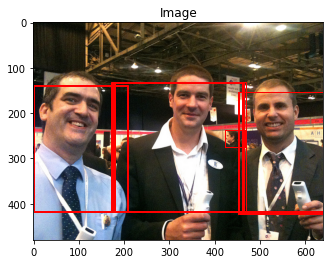

In [545]:
fig, axs = plt.subplots()
plt.imshow(image)
plt.title('Image');

scale_h = 480 / 640
for bbox, cls in zip(preds_bboxes, preds_classes):
    if cls!=0:
        continue
    # Assume each detection is a dictionary with 'bbox' key
    x_center, y_center, width, height = bbox
    height *= scale_h
    y_center *= scale_h
    x = x_center-width/2
    y = y_center-height/2
    print(bbox)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axs.add_patch(rect)

plt.show()

In [ ]:

# Load the original ONNX model
model = onnx_model

# Get a list of the names of all intermediate layers and their output tensor names in the model
all_layer_names = [node.name for node in model.graph.node]
all_output_names = [output.name for node in model.graph.node for output in node.output]

# Modify the ONNX model to add additional output nodes for all layers
for output_name in all_output_names:
    intermediate_layer_value_info = onnx.helper.make_tensor_value_info(
        name=output_name,
        elem_type=onnx.TensorProto.FLOAT,
        shape=(1, 3, 640, 640)  # This should be updated with the correct shape, or left as an empty list []
    )
    model.graph.output.extend([intermediate_layer_value_info])

# Save the modified ONNX model to disk
onnx.save(model, r'modified_yolov8.onnx')

# Create an InferenceSession with the modified model
ort_session = ort.InferenceSession(r'modified_yolov8.onnx')

# Assume img is your input image array preprocessed as per YOLOv8 requirements
img = np.random.randn(1, 3, 640, 640).astype(np.float32)  # Replace with actual image preprocessing

# Perform inference
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)

# Print the shape of the feature space after each layer
for i, out in enumerate(ort_outs):
    print(f'Shape after layer {all_layer_names[i]}: {out.shape}')


In [641]:
def xywh_to_xycwh(xywh_boxes):
    x, y, w, h = xywh_boxes[:, 0], xywh_boxes[:, 1], xywh_boxes[:, 2], xywh_boxes[:, 3]
    x_center = x + w / 2
    y_center = y + h / 2
    return np.column_stack((x_center, y_center, w, h))


def xycwh_to_xywh(xycwh_boxes):
    x_center, y_center, w, h = xycwh_boxes[:, 0], xycwh_boxes[:, 1], xycwh_boxes[:, 2], xycwh_boxes[:, 3]
    x = x_center - w / 2
    y = y_center - h / 2
    return np.column_stack((x, y, w, h))


def xywh_to_x1y1x2y2(xywh_boxes):
    x, y, w, h = xywh_boxes[:, 0], xywh_boxes[:, 1], xywh_boxes[:, 2], xywh_boxes[:, 3]
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    return np.column_stack((x1, y1, x2, y2))


def x1y1x2y2_to_xywh(x1y1x2y2_boxes):
    x1, y1, x2, y2 = x1y1x2y2_boxes[:, 0], x1y1x2y2_boxes[:, 1], x1y1x2y2_boxes[:, 2], x1y1x2y2_boxes[:, 3]
    x = x1
    y = y1
    w = x2 - x1
    h = y2 - y1
    return np.column_stack((x, y, w, h))


In [800]:
def calc_f1(precision, recall):
    return (2*precision*recall)/(precision+recall) if (precision+recall)!=0 else 0


In [789]:
# Example usage
pred_boxes = np.array([[50, 50, 39, 30], [60, 60, 40, 40], [80, 80, 20, 20]])
true_boxes = np.array([[50, 50, 30, 30], [70, 70, 30, 30]])

precision, recall = calculate_precision_recall(pred_boxes, true_boxes, iou_threshold=0.5)
f_score = calc_f1(precision, recall)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f_score: {f_score}')


Precision: 0.6666666666666666
Recall: 1.0
f_score: 0.8


In [ ]:
def draw_ann_on_image(image, annotations):
    # bbox of xywh -> xy: top-left
    
    # Create a figure and an Axes object
    fig, ax = plt.subplots()
    plt.imshow(image)

    for bbox in annotations:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    

In [68]:
person_images

{'000000397133.jpg': {'license': 4,
  'file_name': '000000397133.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
  'height': 427,
  'width': 640,
  'date_captured': '2013-11-14 17:02:52',
  'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
  'id': 397133,
  'annotations': [([388.66, 69.92, 109.41, 277.62], 1, 'person'),
   ([0.0, 262.81, 62.16, 36.77], 1, 'person')]},
 '000000252219.jpg': {'license': 4,
  'file_name': '000000252219.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000252219.jpg',
  'height': 428,
  'width': 640,
  'date_captured': '2013-11-14 22:32:02',
  'flickr_url': 'http://farm4.staticflickr.com/3446/3232237447_13d84bd0a1_z.jpg',
  'id': 252219,
  'annotations': [([326.28, 174.56, 71.24, 197.25], 1, 'person'),
   ([9.79, 167.06, 121.94, 226.45], 1, 'person'),
   ([510.44, 171.27, 123.66, 215.76], 1, 'person')]},
 '000000087038.jpg': {'license': 1,
  'file_name': '000000087038.jpg',
  'coco_url'